# Logistic regression analysis (part 2/2 of pharmacovigilance analysis)

## Author: Finn Benned Hansen 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import Helper_functions
import importlib
import statsmodels.api as sm
importlib.reload(Helper_functions)

pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)
sns.set_style("whitegrid")
sns.set_context("talk")
home = True
AF = True
Arr = False
comorbidity = True
comorbidity_explicit = True
top5 = False


In [2]:
path1 = 'O:/CardiacProteomics/Project data/Conduction system heart failure (SM+MS+KK+AS+ET)/Analysis/FAERS/Troublesshooting/'
reac = pd.read_csv(path1 + 'REAC_2021Q2.tsv', sep = '\t')
indi = pd.read_csv(path1 + 'INDI_2021Q2.tsv', sep = '\t')
demo1 = pd.read_csv(path1 + 'DEMO_2021Q2.tsv', sep = '\t')
drug1 = pd.read_csv(path1 + 'DRUG_2021Q2.tsv', sep = '\t')

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (11,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import json
with open(path1 + 'primaryids_demo_2021Q2_maxcaseversion.json', 'r') as f:
    primids = json.load(f)

In [4]:
print(drug1.shape,drug1[drug1.primaryid.isin(primids)].shape,len(primids))

(40863867, 20) (33893593, 20) 9077024


In [5]:
reac = reac[reac.primaryid.isin(primids)]
indi = indi[indi.primaryid.isin(primids)]
demo1 = demo1[demo1.primaryid.isin(primids)]
drug1 = drug1[drug1.primaryid.isin(primids)]

In [6]:
prim_tmp = reac.primaryid.unique().tolist()
indi = indi[indi.primaryid.isin(prim_tmp)]
demo1 = demo1[demo1.primaryid.isin(prim_tmp)]
drug1 = drug1[drug1.primaryid.isin(prim_tmp)]


In [7]:
reac_prims = reac[(reac.pt.str.contains('tachycar')) | (reac.pt.str.contains('Tachycar'))].primaryid.unique().tolist()

# To test code only use below

In [8]:
### Comorbidity
ae1 = pd.read_excel(path1 + 'AE hierachies_FAERS_12Q419Q2.xlsx', skiprows=4,sheet_name= 'Hierarchy Analysis')
ae1 = ae1[ae1['Primary SOC'] == 'Y']
ca_hlgt = ae1[ae1['HLGT'] == 'Cardiac arrhythmias'][' Term'].tolist()


if top5:
    comorbidity_SOC = [ 'Cardiac disorders','Musculoskeletal and connective tissue disorders', 
                       'Respiratory, thoracic and mediastinal disorders','Metabolism and nutrition disorders',
                      'Vascular disorders']
else:
    comorbidity_SOC = [ 'Cardiac disorders','Metabolism and nutrition disorders',
                       'Respiratory, thoracic and mediastinal disorders', 'Vascular disorders']

comorbidities = []
for soc in comorbidity_SOC:
    ae1_comorbidity = ae1[ae1.SOC.isin([soc])].HLGT.to_list()
    ae = ae1[ae1['HLGT'].isin(ae1_comorbidity)]
    pt = ae[' Term'].tolist()
    pt = list(set(pt) - set(ca_hlgt))
    df_tmp = indi[indi['indi_pt'].isin(pt)]
    comorbidities.append(df_tmp['primaryid'].tolist())
    
df_tmp = indi[indi['indi_pt'].isin(ca_hlgt)]
comorbidities.append(df_tmp['primaryid'].tolist())    

In [9]:
print([len(i) for i in comorbidities])

[205995, 729813, 648172, 513523, 173580]


In [10]:
drug = drug1[drug1['role_cod'] == 'PS']
drug['prod_ai'] = drug['prod_ai'].astype(str)
drug = drug.drop_duplicates(subset = 'primaryid')

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
casid_drug = drug.caseid.unique().tolist()

In [12]:
d_tmp = pd.read_excel(r'J:\BMI\CardiacProteomics\Project data\Conduction system heart failure (SM+MS+KK+AS+ET)\Analysis\FAERS\CS_HF_SN_all_signif_proteins+kinases_human_orthologs_drughits_bootstrap_2021Q2clean_gene-drughits_Brady-stats_20211130.xlsx')
print(len(d_tmp))
Ibs = d_tmp[(d_tmp['p-value']<0.05)].Drug.unique().tolist()[:-1]
print(len(Ibs))
Ibs

75
41


['TRAZODONE',
 'HYDROXYZINE',
 'AMITRIPTYLINE',
 'CYCLOBENZAPRINE',
 'DIPHENHYDRAMINE',
 'LOPERAMIDE',
 'METHADONE',
 'SOTALOL',
 'ESTRADIOL',
 'DRONEDARONE',
 'PAROXETINE',
 'RALOXIFENE',
 'PROPOFOL',
 'FLUOXETINE',
 'HALOPERIDOL',
 'DOFETILIDE',
 'CITALOPRAM',
 'RISPERIDONE',
 'OXYBUTYNIN',
 'FLECAINIDE',
 'AMIODARONE',
 'VERAPAMIL',
 'NALOXONE',
 'DOXAZOSIN',
 'ENALAPRIL',
 'IVABRADINE',
 'TRAMADOL',
 'OLANZAPINE',
 'GLYCOPYRROLATE',
 'ACLIDINIUM',
 'NICOTINE',
 'TIOTROPIUM',
 'ROCURONIUM',
 'IPRATROPIUM',
 'AZITHROMYCIN',
 'ATORVASTATIN',
 'FULVESTRANT',
 'ORLISTAT',
 'LEVOTHYROXINE',
 'HYDROCHLOROTHIAZIDE',
 'DEXAMETHASONE']

In [13]:
df_drugs = pd.read_csv(path1 + '/Products.txt', sep = '\t',error_bad_lines =False)
df_dates = pd.read_csv(path1 + '/Submissions_2.txt', sep = '\t',parse_dates=['SubmissionStatusDate'],error_bad_lines =False)
ibs_clean =sorted(list(set([i.split(' ')[0] for i in sorted(Ibs) if '\\' not in i ])))

ib_name,dat = [],[]
for ib in ibs_clean[:]:
    try:
        appno = df_drugs[df_drugs.ActiveIngredient.str.contains(ib)].iat[0,0]
        
        dat.append(df_dates[(df_dates.ApplNo == appno)].iat[0,5])
        ib_name.append(ib)
    except:
        print(ib)
dates = pd.DataFrame({'Drug':ib_name,'FDA Approval (source: Drugs.com)': dat})

dates

b'Skipping line 35244: expected 8 fields, saw 9\nSkipping line 35245: expected 8 fields, saw 9\nSkipping line 35246: expected 8 fields, saw 9\n'


,Drug,FDA Approval (source: Drugs.com)
0,ACLIDINIUM,2012-07-23
1,AMIODARONE,1985-12-24
2,AMITRIPTYLINE,1961-04-07
3,ATORVASTATIN,1996-12-17
4,AZITHROMYCIN,1991-11-01
5,CITALOPRAM,1998-07-17
6,CYCLOBENZAPRINE,1977-08-26
7,DEXAMETHASONE,1958-10-30
8,DIPHENHYDRAMINE,1946-03-04
9,DOFETILIDE,1999-10-01


In [14]:
drug = Helper_functions.annotate_phenotypes(drug,reac, arrhytmia='CA', home=home)

In [15]:
drug

,primaryid,AF_patient,Bradycardia_patient,Arrhythmia,HF,prod_ai
0,100033366,0,0,0,0,METFORMIN HYDROCHLORIDE\SITAGLIPTIN PHOSPHATE
2,100035512,0,0,0,0,ADALIMUMAB
3,100036903,0,0,0,0,TERIFLUNOMIDE
4,100037647,0,0,0,0,ALENDRONATE SODIUM
12,100038092,0,0,0,0,CALCIUM CHLORIDE\DEXTROSE\MAGNESIUM CHLORIDE\S...
...,...,...,...,...,...,...
40863778,99245568,0,0,0,0,EXEMESTANE
40863779,99310713,0,0,0,0,CYCLOSPORINE
40863785,99310733,0,0,0,0,CYCLOSPORINE
40863795,998827266,0,0,0,0,OMALIZUMAB


In [16]:
ID_list = drug['primaryid'].tolist()
demo = demo1[demo1['primaryid'].isin(ID_list)]

In [17]:
demo = Helper_functions.demo_age_gender_clear(demo)

In [18]:
# Joining dataframes
df_reg = demo.set_index('primaryid').join(drug.set_index('primaryid'))

#fixing stuff
df_reg['sex'].replace(['F','M'],[0,1],inplace=True)
df_reg

,sex,new_age,rept_dt,AF_patient,Bradycardia_patient,Arrhythmia,HF,prod_ai
primaryid,,,,,,,,
3.123117e+07,0,59.0,19971204.0,0,0,0,0,MEPHOBARBITAL
3.127365e+07,1,36.0,19980624.0,0,0,0,0,MIDAZOLAM HYDROCHLORIDE
3.132024e+07,1,0.0,20141121.0,0,0,0,0,DIDANOSINE
3.203092e+07,0,34.0,19981223.0,0,0,0,0,LACTULOSE
3.207753e+07,0,41.0,19990225.0,0,0,1,0,ALATROFLOXACIN MESYLATE
...,...,...,...,...,...,...,...,...
1.923703e+09,1,64.0,20210629.0,0,0,0,0,TIRAGOLUMAB
1.946440e+09,0,60.0,20210629.0,0,0,0,0,HEPARIN SODIUM
9.474120e+09,1,56.0,20200513.0,0,0,0,0,OCTREOTIDE ACETATE


In [19]:
len(df_reg.prod_ai.unique().tolist())

4812

In [20]:
#Removes all drugs not in the Ibs list from PKIdb
unique_prod = df_reg.prod_ai.unique().tolist()
replace_dict = {}

for ib in Ibs:
    for idx,d in enumerate(unique_prod):
        if ib.lower() in d.lower() and '\\' not in d:
            print(ib.upper(),':\t', d)
            replace_dict[d] = ib.upper() 

df_reg.prod_ai = df_reg.prod_ai.map(replace_dict)

TRAZODONE :	 TRAZODONE HYDROCHLORIDE
HYDROXYZINE :	 HYDROXYZINE HYDROCHLORIDE
HYDROXYZINE :	 HYDROXYZINE PAMOATE
AMITRIPTYLINE :	 AMITRIPTYLINE
AMITRIPTYLINE :	 AMITRIPTYLINE HYDROCHLORIDE
CYCLOBENZAPRINE :	 CYCLOBENZAPRINE
CYCLOBENZAPRINE :	 CYCLOBENZAPRINE HYDROCHLORIDE
DIPHENHYDRAMINE :	 DIPHENHYDRAMINE
DIPHENHYDRAMINE :	 DIPHENHYDRAMINE HYDROCHLORIDE
DIPHENHYDRAMINE :	 ACETAMINOPHEN AND OR DEXTROMETHORPHAN AND OR DIPHENHYDRAMINE AND OR GUAIFENESIN AND OR PHENYLEPHRINE AND OR PSEUDOEPHEDRINE
DIPHENHYDRAMINE :	 CETIRIZINE HYDROCHLORIDE OR DIPHENHYDRAMINE HYDROCHLORIDE OR FEXOFENADINE HYDROCHLORIDE OR FLUTICASONE PROPIONATE OR LORATADINE
LOPERAMIDE :	 LOPERAMIDE HYDROCHLORIDE
LOPERAMIDE :	 LOPERAMIDE
METHADONE :	 METHADONE HYDROCHLORIDE
SOTALOL :	 SOTALOL HYDROCHLORIDE
SOTALOL :	 SOTALOL
ESTRADIOL :	 ESTRADIOL
ESTRADIOL :	 ESTRADIOL CYPIONATE
ESTRADIOL :	 ESTRADIOL HEMIHYDRATE
ESTRADIOL :	 ESTRADIOL VALERATE
ESTRADIOL :	 ESTRADIOL ACETATE
ESTRADIOL :	 ETHINYL ESTRADIOL
DRONEDARONE :	 

In [21]:
len(df_reg.prod_ai.unique().tolist())

42

In [22]:
df_reg['prod_ai'].value_counts()

ATORVASTATIN           24992
RISPERIDONE            18312
TIOTROPIUM             17822
LEVOTHYROXINE          15582
DEXAMETHASONE          13841
CITALOPRAM             13588
OLANZAPINE             13353
NICOTINE               10405
TRAMADOL               10256
ESTRADIOL               7706
AZITHROMYCIN            7642
AMIODARONE              7221
FLUOXETINE              6967
PAROXETINE              5196
LOPERAMIDE              4600
DIPHENHYDRAMINE         3348
HYDROCHLOROTHIAZIDE     3242
HALOPERIDOL             3130
FULVESTRANT             2492
METHADONE               2476
DOFETILIDE              2293
PROPOFOL                2240
VERAPAMIL               2093
AMITRIPTYLINE           1895
ACLIDINIUM              1883
OXYBUTYNIN              1812
ORLISTAT                1680
TRAZODONE               1674
RALOXIFENE              1656
ENALAPRIL               1569
ROCURONIUM              1380
IPRATROPIUM             1296
IVABRADINE              1294
HYDROXYZINE             1285
GLYCOPYRROLATE

In [23]:
# #### KEEP ONLY IBS WITH 500+ ENTRIES ###
v_count = df_reg['prod_ai'].value_counts()
to_remove = v_count[v_count < 500].index.tolist()
to_remain = list(set(Ibs) - set(to_remove))
dict_remain = {i:i for i in to_remain}
df_reg['prod_ai'] = df_reg['prod_ai'].map(dict_remain) #,na_action='ignore')

In [24]:
len(df_reg.prod_ai.unique().tolist())

41

In [25]:
# Limit to after FDA approval
df_date = df_reg.loc[df_reg['rept_dt'] > 20000000, :]
df_date['rept_dt'] =  pd.to_datetime(df_date['rept_dt'], format='%Y%m%d')
df_date = df_date[~df_date.prod_ai.isnull()]
dates = dates.set_index('Drug')
dates_dict = dates.to_dict()

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
dates_dict['FDA Approval (source: Drugs.com)'].keys()

dict_keys(['ACLIDINIUM', 'AMIODARONE', 'AMITRIPTYLINE', 'ATORVASTATIN', 'AZITHROMYCIN', 'CITALOPRAM', 'CYCLOBENZAPRINE', 'DEXAMETHASONE', 'DIPHENHYDRAMINE', 'DOFETILIDE', 'DOXAZOSIN', 'DRONEDARONE', 'ENALAPRIL', 'ESTRADIOL', 'FLECAINIDE', 'FLUOXETINE', 'FULVESTRANT', 'GLYCOPYRROLATE', 'HALOPERIDOL', 'HYDROCHLOROTHIAZIDE', 'HYDROXYZINE', 'IPRATROPIUM', 'IVABRADINE', 'LEVOTHYROXINE', 'LOPERAMIDE', 'METHADONE', 'NALOXONE', 'NICOTINE', 'OLANZAPINE', 'ORLISTAT', 'OXYBUTYNIN', 'PAROXETINE', 'PROPOFOL', 'RALOXIFENE', 'RISPERIDONE', 'ROCURONIUM', 'SOTALOL', 'TIOTROPIUM', 'TRAMADOL', 'TRAZODONE', 'VERAPAMIL'])

In [27]:
df_reg[df_reg.prod_ai.isna()]

,sex,new_age,rept_dt,AF_patient,Bradycardia_patient,Arrhythmia,HF,prod_ai
primaryid,,,,,,,,
3.123117e+07,0,59.0,19971204.0,0,0,0,0,NaN
3.127365e+07,1,36.0,19980624.0,0,0,0,0,NaN
3.132024e+07,1,0.0,20141121.0,0,0,0,0,NaN
3.203092e+07,0,34.0,19981223.0,0,0,0,0,NaN
3.207753e+07,0,41.0,19990225.0,0,0,1,0,NaN
...,...,...,...,...,...,...,...,...
1.923703e+09,1,64.0,20210629.0,0,0,0,0,NaN
1.946440e+09,0,60.0,20210629.0,0,0,0,0,NaN
9.474120e+09,1,56.0,20200513.0,0,0,0,0,NaN


In [28]:
affected_drug = []
unapproved_patients = []
for idx, d in enumerate(df_date.prod_ai.unique()):
    approval_date = dates_dict['FDA Approval (source: Drugs.com)'][d]#.capitalize()]
    df_date_drug = df_date[df_date.prod_ai == d]
    df_date_drug = df_date_drug[df_date_drug.rept_dt < approval_date]
    unapproved_patients.extend(df_date_drug.index.tolist())
    if len(df_date_drug.index.tolist()):
        affected_drug.append([d, len(df_date_drug.index.tolist())])
    
df_reg = df_reg.drop(['rept_dt'], axis=1)
print('removed patients:', len(unapproved_patients))
df_reg = df_reg[~df_reg.index.isin(unapproved_patients)]


removed patients: 0


In [29]:
demo1 = demo1[demo1.primaryid.isin(df_reg.index.tolist())]
demo1 = demo1.set_index('primaryid')

# none case specific rows
duplicate_check = list(set(demo1.columns.tolist()) - set(['primaryid','caseid','caseversion','rept_dt','init_fda_dt','fda_dt']))

#getting information
test = demo1[duplicate_check]
duplicate = test[test.duplicated()].index.tolist()

nonduplicate_patients = test.drop_duplicates().index.tolist()

In [30]:
df_reg = pd.get_dummies(df_reg,prefix=[''],columns=['prod_ai'],prefix_sep='')
df_reg

,sex,new_age,AF_patient,Bradycardia_patient,Arrhythmia,HF,ACLIDINIUM,AMIODARONE,AMITRIPTYLINE,ATORVASTATIN,AZITHROMYCIN,CITALOPRAM,CYCLOBENZAPRINE,DEXAMETHASONE,DIPHENHYDRAMINE,DOFETILIDE,DOXAZOSIN,DRONEDARONE,ENALAPRIL,ESTRADIOL,FLECAINIDE,FLUOXETINE,FULVESTRANT,GLYCOPYRROLATE,HALOPERIDOL,HYDROCHLOROTHIAZIDE,HYDROXYZINE,IPRATROPIUM,IVABRADINE,LEVOTHYROXINE,LOPERAMIDE,METHADONE,NICOTINE,OLANZAPINE,ORLISTAT,OXYBUTYNIN,PAROXETINE,PROPOFOL,RALOXIFENE,RISPERIDONE,ROCURONIUM,SOTALOL,TIOTROPIUM,TRAMADOL,TRAZODONE,VERAPAMIL
primaryid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.123117e+07,0,59.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.127365e+07,1,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.132024e+07,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.203092e+07,0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.207753e+07,0,41.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.923703e+09,1,64.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1.946440e+09,0,60.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9.474120e+09,1,56.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
Columns_Ibs = df_reg.columns.tolist()[6:]
Columns_Non_Ibs = df_reg.columns.tolist()[:6]

In [32]:
df_reg[Columns_Ibs]

,ACLIDINIUM,AMIODARONE,AMITRIPTYLINE,ATORVASTATIN,AZITHROMYCIN,CITALOPRAM,CYCLOBENZAPRINE,DEXAMETHASONE,DIPHENHYDRAMINE,DOFETILIDE,DOXAZOSIN,DRONEDARONE,ENALAPRIL,ESTRADIOL,FLECAINIDE,FLUOXETINE,FULVESTRANT,GLYCOPYRROLATE,HALOPERIDOL,HYDROCHLOROTHIAZIDE,HYDROXYZINE,IPRATROPIUM,IVABRADINE,LEVOTHYROXINE,LOPERAMIDE,METHADONE,NICOTINE,OLANZAPINE,ORLISTAT,OXYBUTYNIN,PAROXETINE,PROPOFOL,RALOXIFENE,RISPERIDONE,ROCURONIUM,SOTALOL,TIOTROPIUM,TRAMADOL,TRAZODONE,VERAPAMIL
primaryid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.123117e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.127365e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.132024e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.203092e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.207753e+07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.923703e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1.946440e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9.474120e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
df_reg[Columns_Ibs].sum()

ACLIDINIUM              1883
AMIODARONE              7221
AMITRIPTYLINE           1895
ATORVASTATIN           24992
AZITHROMYCIN            7642
CITALOPRAM             13588
CYCLOBENZAPRINE          651
DEXAMETHASONE          13841
DIPHENHYDRAMINE         3348
DOFETILIDE              2293
DOXAZOSIN                994
DRONEDARONE              850
ENALAPRIL               1569
ESTRADIOL               7706
FLECAINIDE               866
FLUOXETINE              6967
FULVESTRANT             2492
GLYCOPYRROLATE          1094
HALOPERIDOL             3130
HYDROCHLOROTHIAZIDE     3242
HYDROXYZINE             1285
IPRATROPIUM             1296
IVABRADINE              1294
LEVOTHYROXINE          15582
LOPERAMIDE              4600
METHADONE               2476
NICOTINE               10405
OLANZAPINE             13353
ORLISTAT                1680
OXYBUTYNIN              1812
PAROXETINE              5196
PROPOFOL                2240
RALOXIFENE              1656
RISPERIDONE            18312
ROCURONIUM    

In [34]:
test = df_reg[Columns_Ibs].copy()
test = test.groupby('primaryid').sum()
df_reg = df_reg[Columns_Non_Ibs].join(test)
test = None
df_reg = df_reg.reset_index().drop_duplicates().set_index('primaryid')

In [35]:
total = df_reg.apply(pd.Series.sum)
sick_count = df_reg[df_reg['Bradycardia_patient'] == 1].apply(pd.Series.sum)

In [36]:
print('--------------- Counting distribution ---------------')
print('Variable\t\tSick\t\tTotal\t\tPercentage')
for i in range(total.shape[0]):
    print(total.index[i], sick_count[i],total.iloc[i], round(100*sick_count[i] / total[i],2),sep='\t\t')

--------------- Counting distribution ---------------
Variable		Sick		Total		Percentage
sex		9894.0		1978796.0		0.5
new_age		1212001.0		275837159.0		0.44
AF_patient		757.0		27364.0		2.77
Bradycardia_patient		20734.0		20734.0		100.0
Arrhythmia		20734.0		114453.0		18.12
HF		1632.0		166068.0		0.98
ACLIDINIUM		0.0		1883.0		0.0
AMIODARONE		514.0		7221.0		7.12
AMITRIPTYLINE		26.0		1895.0		1.37
ATORVASTATIN		97.0		24992.0		0.39
AZITHROMYCIN		85.0		7642.0		1.11
CITALOPRAM		221.0		13588.0		1.63
CYCLOBENZAPRINE		10.0		651.0		1.54
DEXAMETHASONE		65.0		13841.0		0.47
DIPHENHYDRAMINE		18.0		3348.0		0.54
DOFETILIDE		15.0		2293.0		0.65
DOXAZOSIN		21.0		994.0		2.11
DRONEDARONE		17.0		850.0		2.0
ENALAPRIL		27.0		1569.0		1.72
ESTRADIOL		0.0		7706.0		0.0
FLECAINIDE		95.0		866.0		10.97
FLUOXETINE		134.0		6967.0		1.92
FULVESTRANT		4.0		2492.0		0.16
GLYCOPYRROLATE		10.0		1094.0		0.91
HALOPERIDOL		47.0		3130.0		1.5
HYDROCHLOROTHIAZIDE		44.0		3242.0		1.36
HYDROXYZINE		15.0		1285.0		1.17
IPRATROPIUM		2.0		1296.

#### PKI patient average adverse reactions:

In [37]:
df_reg2 = df_reg[df_reg.new_age > 18]
df_reg2 = df_reg[df_reg.index.isin(nonduplicate_patients)]

In [38]:
df_reg2

,sex,new_age,AF_patient,Bradycardia_patient,Arrhythmia,HF,ACLIDINIUM,AMIODARONE,AMITRIPTYLINE,ATORVASTATIN,AZITHROMYCIN,CITALOPRAM,CYCLOBENZAPRINE,DEXAMETHASONE,DIPHENHYDRAMINE,DOFETILIDE,DOXAZOSIN,DRONEDARONE,ENALAPRIL,ESTRADIOL,FLECAINIDE,FLUOXETINE,FULVESTRANT,GLYCOPYRROLATE,HALOPERIDOL,HYDROCHLOROTHIAZIDE,HYDROXYZINE,IPRATROPIUM,IVABRADINE,LEVOTHYROXINE,LOPERAMIDE,METHADONE,NICOTINE,OLANZAPINE,ORLISTAT,OXYBUTYNIN,PAROXETINE,PROPOFOL,RALOXIFENE,RISPERIDONE,ROCURONIUM,SOTALOL,TIOTROPIUM,TRAMADOL,TRAZODONE,VERAPAMIL
primaryid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.123117e+07,0,59.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.127365e+07,1,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.132024e+07,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.203092e+07,0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.207753e+07,0,41.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.923703e+09,1,64.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1.946440e+09,0,60.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9.474120e+09,1,56.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
df_reg2['Tachycardia'] = 0
for ind,rows in df_reg2.loc[list(set(df_reg2.index) & set(reac_prims))].iterrows():
    df_reg2.at[ind,'Tachycardia'] = 1
df_reg2.Tachycardia.sum()

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


38625

In [40]:
df_reg2

,sex,new_age,AF_patient,Bradycardia_patient,Arrhythmia,HF,ACLIDINIUM,AMIODARONE,AMITRIPTYLINE,ATORVASTATIN,AZITHROMYCIN,CITALOPRAM,CYCLOBENZAPRINE,DEXAMETHASONE,DIPHENHYDRAMINE,DOFETILIDE,DOXAZOSIN,DRONEDARONE,ENALAPRIL,ESTRADIOL,FLECAINIDE,FLUOXETINE,FULVESTRANT,GLYCOPYRROLATE,HALOPERIDOL,HYDROCHLOROTHIAZIDE,HYDROXYZINE,IPRATROPIUM,IVABRADINE,LEVOTHYROXINE,LOPERAMIDE,METHADONE,NICOTINE,OLANZAPINE,ORLISTAT,OXYBUTYNIN,PAROXETINE,PROPOFOL,RALOXIFENE,RISPERIDONE,ROCURONIUM,SOTALOL,TIOTROPIUM,TRAMADOL,TRAZODONE,VERAPAMIL,Tachycardia
primaryid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.123117e+07,0,59.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.127365e+07,1,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.132024e+07,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.203092e+07,0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.207753e+07,0,41.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.923703e+09,1,64.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1.946440e+09,0,60.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9.474120e+09,1,56.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# All inhibs

In [41]:
if comorbidity_explicit:
    if top5:
        comorbidity_SOC_short = ['Other cardiac comorbidity', 'musculoskeletal comorbidity', 'Respiratory comorbidity',
                                'Metabolism comorbidity', 'Vascular comorbidity']
    else:
        comorbidity_SOC_short = ['Other cardiac comorbidity', 'Metabolism comorbidity', 'Respiratory comorbidity', 'Vascular comorbidity']
    comorbidity_SOC_short.append('History of arrhythmia')


In [42]:
df_reg2['new_age'] = (df_reg2['new_age']-df_reg2['new_age'].mean())/df_reg2['new_age'].std()
df_reg2 = df_reg2.rename(columns={'new_age':'age'})
df_reg2

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sex,age,AF_patient,Bradycardia_patient,Arrhythmia,HF,ACLIDINIUM,AMIODARONE,AMITRIPTYLINE,ATORVASTATIN,AZITHROMYCIN,CITALOPRAM,CYCLOBENZAPRINE,DEXAMETHASONE,DIPHENHYDRAMINE,DOFETILIDE,DOXAZOSIN,DRONEDARONE,ENALAPRIL,ESTRADIOL,FLECAINIDE,FLUOXETINE,FULVESTRANT,GLYCOPYRROLATE,HALOPERIDOL,HYDROCHLOROTHIAZIDE,HYDROXYZINE,IPRATROPIUM,IVABRADINE,LEVOTHYROXINE,LOPERAMIDE,METHADONE,NICOTINE,OLANZAPINE,ORLISTAT,OXYBUTYNIN,PAROXETINE,PROPOFOL,RALOXIFENE,RISPERIDONE,ROCURONIUM,SOTALOL,TIOTROPIUM,TRAMADOL,TRAZODONE,VERAPAMIL,Tachycardia
primaryid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.123117e+07,0,0.180504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.127365e+07,1,-0.948906,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.132024e+07,1,-2.716677,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.203092e+07,0,-1.047115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.207753e+07,0,-0.703382,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.923703e+09,1,0.426028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1.946440e+09,0,0.229609,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9.474120e+09,1,0.033189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
drug_drops = d_tmp[(d_tmp.Drug.isin(list(df_reg2.columns[6:-1]))) & (d_tmp['%Brady/Total AEs']<0.003)].Drug.unique().tolist()
len(drug_drops)

4

In [44]:
outcomes = ['AF_patient','Bradycardia_patient','Arrhythmia','HF','Tachycardia']
outcome = 'Bradycardia_patient'
log_reg = []
for i in range(1):
    y = df_reg2[outcome].values
    X = df_reg2.drop(outcomes,axis=1)
    drop = X.columns[X.sum(axis=0) == 0].tolist()
    if len(drop) != 0:
        X = X.drop(drop, axis=1)
    X = X.drop(drug_drops, axis = 1)
    X['intercept'] = 1

    if comorbidity:
        for i, comord in enumerate(comorbidities):
            X[comorbidity_SOC_short[i]] = X.index.isin(comord).astype(int)

    logit_model=sm.Logit(y,X)
    result=logit_model.fit(maxiter=60)
    log_reg.append(result)

Optimization terminated successfully.
         Current function value: 0.025964
         Iterations 13


In [45]:
result2 = result
intercept = ['Intercept']

if comorbidity:
    confounders = comorbidity_SOC_short + ['Age','Sex','Cancer patient']
else:
    confounders = ['Age','Sex','Cancer patient']
significant = []
for j in X.drop(['sex','age'], axis = 1).columns:
    if result2.params[j] > 0 and result2.pvalues[j] < 0.05/len(X.columns):
        significant.append(str.capitalize(j))
significant = list(set(significant) - set(['Intercept'] + confounders))

indexes = list(map(str.capitalize,result2.conf_int().index))
int_OR,int_SE = [],[]
cf_OR,cf_SE,cf_order = [],[],[]
nonsignificant,nonsig_OR,nonsig_SE = [],[],[]
sig_OR,sig_SE,sig_order = [],[],[]

for k in range(len(indexes)):
    if indexes[k] in significant:
        sig_OR.append(np.exp(result2.params[k]))
        SE = [np.exp(result2.params[k]-2*result2.bse[k]) - np.exp(result2.params[k])]
        SE.append(np.exp(result2.params[k]+2*result2.bse[k]) - np.exp(result2.params[k]))
        sig_SE.append(SE)
        sig_order.append(indexes[k])
    elif indexes[k] in intercept:
        int_OR.append(np.exp(result2.params[k]))
        SE = [np.exp(result2.params[k]-2*result2.bse[k]) - np.exp(result2.params[k])]
        SE.append(np.exp(result2.params[k]+2*result2.bse[k]) - np.exp(result2.params[k]))
        int_SE.append(SE)
    elif indexes[k] in confounders:
        cf_OR.append(np.exp(result2.params[k]))
        SE = [np.exp(result2.params[k]-2*result2.bse[k]) - np.exp(result2.params[k])]
        SE.append(np.exp(result2.params[k]+2*result2.bse[k]) - np.exp(result2.params[k]))
        cf_SE.append(SE)
        cf_order.append(indexes[k])
    else:
        nonsig_OR.append(np.exp(result2.params[k]))
        nonsignificant.append(indexes[k])
        SE = [np.exp(result2.params[k]-2*result2.bse[k]) - np.exp(result2.params[k])]
        SE.append(np.exp(result2.params[k]+2*result2.bse[k]) - np.exp(result2.params[k]))
        nonsig_SE.append(SE)

In [46]:
#sorted according to size
if len(significant) != 0:
    sig_OR, sig_order, sig_SE = zip(*sorted(zip(sig_OR, sig_order,sig_SE),reverse=True))
    sig_SE = np.abs(np.array(sig_SE)).transpose()

if len(nonsignificant) != 0:
    nonsig_OR, nonsignificant, nonsig_SE = zip(*sorted(zip(nonsig_OR, nonsignificant,nonsig_SE),reverse=True))
    nonsig_SE = np.abs(np.array(nonsig_SE)).transpose()

cf_OR, cf_order, cf_SE = zip(*sorted(zip(cf_OR, cf_order,cf_SE),reverse=True))
cf_SE = np.abs(np.array(cf_SE)).transpose()

int_SE = np.abs(np.array(int_SE)).transpose()

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")
c = sns.color_palette("gist_heat",3)
sns.set_palette(c)


#

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional 

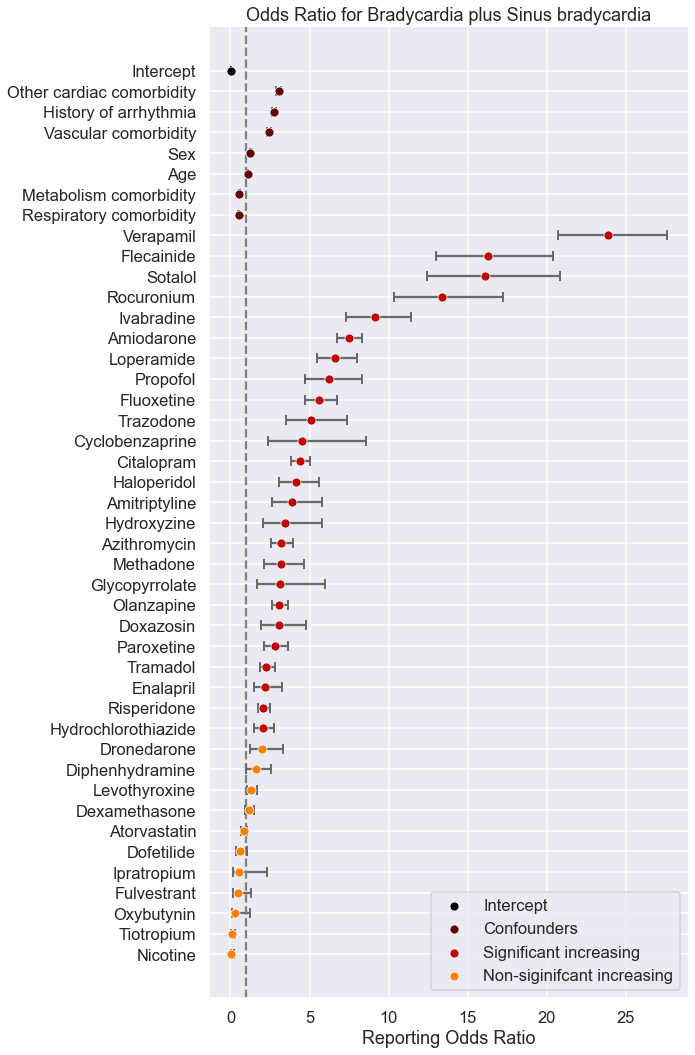

In [47]:
#plotting
fig, ax = plt.subplots(figsize=(10,15))
plt.axvline(x=1,color='grey',zorder=1, linestyle='--') # vertical line

ax.errorbar(int_OR,intercept,xerr=int_SE,ls='none',capsize=5,markeredgewidth=2,zorder=1,color='black')
ax.errorbar(cf_OR,cf_order,xerr=cf_SE,ls='none',capsize=5,markeredgewidth=2, color='dimgray',zorder=1)
ax.errorbar(sig_OR,sig_order,xerr=sig_SE,ls='none',capsize=5,markeredgewidth=2,color='dimgray',zorder=2)
ax.errorbar(nonsig_OR,nonsignificant,xerr=nonsig_SE,ls='none',capsize=5,markeredgewidth=2,color='dimgray',zorder=1)

plt.gca().invert_yaxis()

plt.title('Odds Ratio for Bradycardia plus Sinus bradycardia')

plt.xlabel('Reporting Odds Ratio')

sns.scatterplot(int_OR,intercept,label='Intercept',color='black',zorder=3)
sns.scatterplot(cf_OR,cf_order,label='Confounders',zorder=3)
sns.scatterplot(sig_OR,sig_order,label='Significant increasing',zorder=3)
sns.scatterplot(nonsig_OR,nonsignificant,label='Non-siginifcant increasing',zorder=3)

ax.legend(loc=4)
sns.despine()
plt.tight_layout()

plt.show()